In [19]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import warnings
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
from plotly.graph_objs import *

import tweepy
import itertools
import json
from datetime import datetime

In [20]:
#plotly_key = os.environ["PLOTLY_KEY"]
#mapbox_token = "pk.eyJ1IjoiYW14bW9uZ29vc2UiLCJhIjoiY2plbG1iYml3MXdrYjJxbW80YW53dWE0bCJ9.3VkhNFfkrJISw42FzdDbRA"
#plotly.tools.set_credentials_file(username='amxmongoose', api_key=plotly_key)

Data Used:
    1. U.S. census data
    2. County health data
    3. Air quality data
    
Objectives:
    1. Identify relationship between geographic information and health statistics
    2. Determine is there is a correlation between geographic air quality and health quality
    3. Show healthiest/unhealthiest places in the united states both in air quality and health statistics
    
City by region: How do they compare? Questions:

Which city/region has the best air quality?
Which city/region has the best income (range or median)?
Which city/region has the best health statistics?
Is there a correlation between air quality and income?
Is there a correlation between air quality and health?
Is there a correlation between income and health?
    

In [21]:
health_data_path = os.path.join('Data Sets', 'health_data', 'SUMMARYMEASURESOFHEALTH.csv')
fields = ['CHSI_County_Name','CHSI_State_Name','ALE','All_Death','Health_Status']
health_df = pd.read_csv(health_data_path, skipinitialspace=True, usecols=fields)
health_df = health_df.rename(columns={'CHSI_County_Name':'County','CHSI_State_Name':'State'})

In [22]:
census_data_path = os.path.join('Data Sets', 'acs2015_county_data.csv')
fields = ['State', 'County', 'TotalPop', 'Income', 'IncomePerCap', 'Poverty',
       'ChildPoverty', 'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'Unemployment']
census_df = pd.read_csv(census_data_path, skipinitialspace=True, usecols=fields)

In [23]:
merged_df_1 = pd.merge(health_df,census_df,on=['County','State'],how='outer')

In [24]:
air_data_path = os.path.join('Data Sets', 'annual_aqi_by_county_2017.csv')
fields = ['State', 'County', 'Max AQI', 'Median AQI','Unhealthy Days']
air_df = pd.read_csv(air_data_path, skipinitialspace=True, usecols=fields)

In [25]:
merged_df = pd.merge(merged_df_1,air_df,on=['County','State'],how='outer')
merged_df = merged_df.dropna(subset = ['Max AQI'])

In [26]:
health_risk_path = os.path.join('Data Sets', 'health_data', 'RISKFACTORSANDACCESSTOCARE.csv')
fields = ['CHSI_County_Name','CHSI_State_Name','No_Exercise','Few_Fruit_Veg','Obesity','High_Blood_Pres','Smoker','Uninsured']
health_risk_df = pd.read_csv(health_risk_path, skipinitialspace=True, usecols=fields)
health_risk_df = health_risk_df.rename(columns={'CHSI_County_Name':'County','CHSI_State_Name':'State'})

In [27]:
merged_df_2 = pd.merge(merged_df,health_risk_df,on=['County','State'],how='outer')
merged_df_2.head()

,County,State,ALE,All_Death,Health_Status,TotalPop,Income,IncomePerCap,Poverty,ChildPoverty,...,Unemployment,Unhealthy Days,Max AQI,Median AQI,No_Exercise,Few_Fruit_Veg,Obesity,High_Blood_Pres,Smoker,Uninsured
0,Baldwin,Alabama,76.6,856.9,15.4,195121.0,50254.0,27317.0,13.4,19.2,...,7.5,0.0,108.0,41.0,27.2,76.2,23.6,30.5,24.6,19798.0
1,Clay,Alabama,74.9,950.3,-1111.1,13537.0,35327.0,18905.0,16.7,22.5,...,9.4,0.0,66.0,27.0,-1111.1,-1111.1,-1111.1,-1111.1,23.9,2320.0
2,Colbert,Alabama,75.3,964.4,20.3,54444.0,40576.0,22546.0,17.4,26.1,...,9.0,0.0,63.0,41.0,30.2,76.9,30.1,-1111.1,21.7,8141.0
3,DeKalb,Alabama,75.1,960.6,22.0,71068.0,38192.0,18411.0,18.7,25.2,...,7.7,0.0,80.0,40.0,37.0,80.7,24.3,35.3,19.1,12260.0
4,Elmore,Alabama,75.2,946.9,15.1,80763.0,53555.0,24381.0,13.6,20.5,...,8.3,0.0,58.0,38.0,27.7,85.0,24.8,23.0,22.6,8320.0


Text(9.925,0.5,'No Exercise Score')

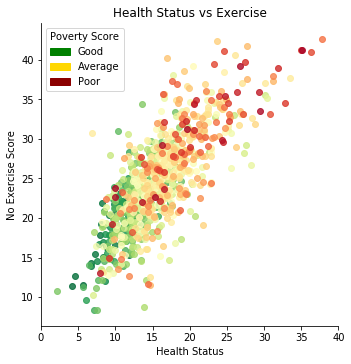

In [28]:
merged_df_reg = merged_df_2[merged_df_2['No_Exercise']>0]
merged_df_reg = merged_df_reg[merged_df_reg['Health_Status']>0]
ax = sns.lmplot(x='Health_Status',
                y='No_Exercise',
                data=merged_df_reg,
                hue='Poverty',
                palette='RdYlGn_r',
                legend=False,
                fit_reg=False
                )
plt.title('Health Status vs Exercise')
red_patch = mpatches.Patch(color='darkred', label='Poor')
yellow_patch = mpatches.Patch(color='gold', label='Average')
green_patch = mpatches.Patch(color='green', label='Good')
plt.legend(title='Poverty Score',handles=[green_patch,yellow_patch,red_patch])
plt.xlabel('Health Status',fontsize=10)
plt.ylabel('No Exercise Score',fontsize=10)

<function matplotlib.pyplot.show>

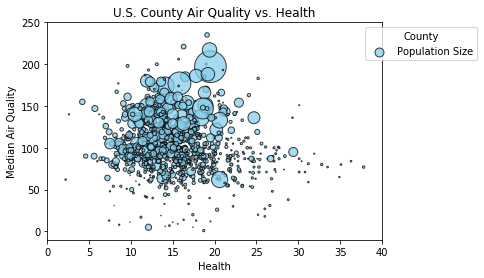

In [29]:
#Comparing US Air Quality vs Health
us_y = [merged_df['Max AQI']]

def scatter_plot_us(dfcolumn):
    return plt.scatter(x=merged_df['Health_Status'], 
            y=dfcolumn,
            edgecolors = 'black',
            color="skyblue",
            s=merged_df['TotalPop']/10000,
            marker = 'o',
            alpha=0.75,
            linewidth = 1.0)
for i in us_y:
    scatter_plot_us(i)
    
plt.legend(['Population Size'],
           title=('County'), 
           bbox_to_anchor=(1.3,1), 
           fancybox=True, 
           fontsize=10, 
           markerscale=0.4)

plt.title('U.S. County Air Quality vs. Health')
plt.xlabel('Health',fontsize=10)
plt.ylabel('Median Air Quality',fontsize=10)
plt.xlim(0,40)
plt.ylim(-10,250)
plt.show

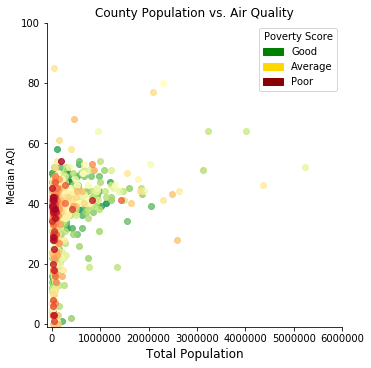

In [30]:
#City Size vs. Air quality
merged_df_city = merged_df[merged_df['Health_Status']>0]
ay = sns.lmplot(x='TotalPop',
                y='Median AQI',
                data=merged_df_city,
                hue='Health_Status',
                palette='RdYlGn_r',
                legend=False,
                fit_reg=False)
ay.set(xlim=(-100000,6000000))
ay.set(ylim=(-1,100))
plt.xlabel('Total Population',fontsize=12)
plt.title('County Population vs. Air Quality')
plt.legend(title='Poverty Score',handles=[green_patch,yellow_patch,red_patch])

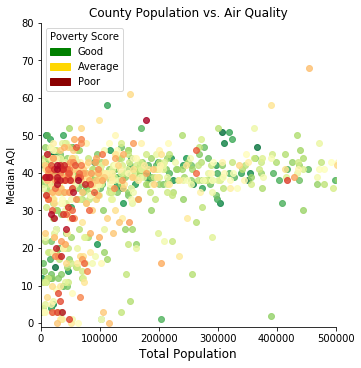

In [31]:
az = sns.lmplot(x='TotalPop',
                y='Median AQI',
                data=merged_df_city,
                hue='Health_Status',
                palette='RdYlGn_r',
                legend=False,
                fit_reg=False)
az.set(xlim=(-100,500000))
az.set(ylim=(-1,80))
plt.xlabel('Total Population',fontsize=12)
plt.title('County Population vs. Air Quality')
plt.legend(title='Poverty Score',handles=[green_patch,yellow_patch,red_patch])

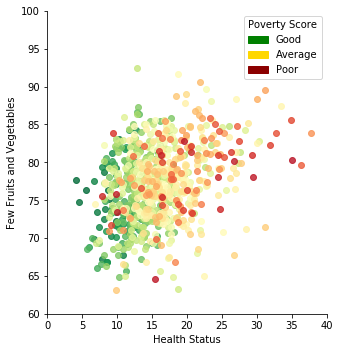

In [32]:
ab = sns.lmplot(x='Health_Status',
                y='Few_Fruit_Veg',
                data=merged_df_2,
                hue='Poverty',
                palette='RdYlGn_r',
                legend=False,
                fit_reg=False)
ab.set(xlim=(0,40))
ab.set(ylim=(60,100))
plt.xlabel('Health Status',fontsize=10)
plt.ylabel('Few Fruits and Vegetables')
plt.legend(title='Poverty Score',handles=[green_patch,yellow_patch,red_patch])

<function matplotlib.pyplot.show>

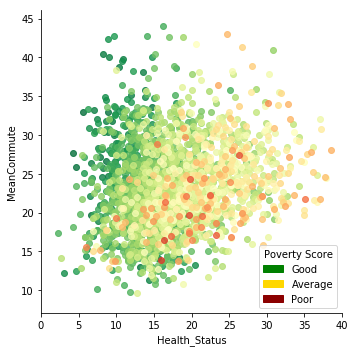

In [33]:
#Health Status vs. Mean Commute
ac = sns.lmplot(x='Health_Status',
                y='MeanCommute',
                data=merged_df_1,
                hue='Poverty',
                palette='RdYlGn_r',
                legend=False,
                fit_reg=False)
ac.set(xlim=(0,40))
plt.legend(title='Poverty Score',handles=[green_patch,yellow_patch,red_patch])
plt.show

(0, 40)

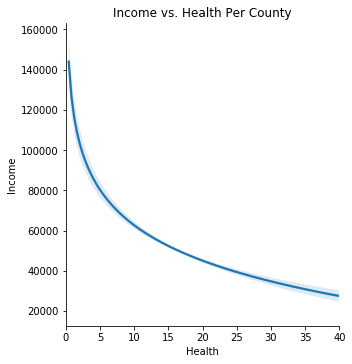

In [36]:
#Income vs Health
warnings.filterwarnings('ignore')
merged_df_reg2 = merged_df_2[merged_df_2['Income']>0]
merged_df_reg2 = merged_df_reg2[merged_df_reg2['Health_Status']>0]
ad = sns.lmplot(x='Health_Status',
                y='Income',
                data=merged_df_reg2,
                legend=False,
                logx=True,
                scatter_kws={'color':'teal','alpha':0.}
               )

plt.title('Income vs. Health Per County')
plt.xlabel('Health',fontsize=10)
plt.ylabel('Income',fontsize=10)    
plt.xlim(0,40)

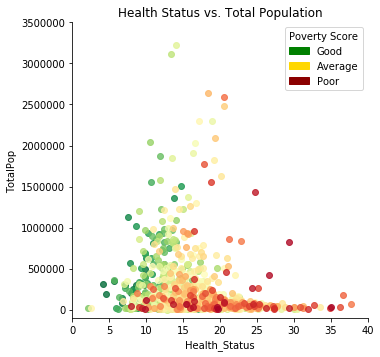

In [35]:
#Population vs Health
ae = sns.lmplot(x='Health_Status',
                y='TotalPop',
                data=merged_df_reg2,
                hue='Poverty',
                palette='RdYlGn_r',
                legend=False,
                fit_reg=False)   
plt.xlim(0,40)
plt.ylim(-100000,3500000)
plt.title('Health Status vs. Total Population')
plt.legend(title='Poverty Score',handles=[green_patch,yellow_patch,red_patch])